In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qiskit
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from hybrid_nn import HybridNNModel, QuantumCircuit, Net, MyDataset, Hybrid

Expected value for rotation pi 0.47


/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


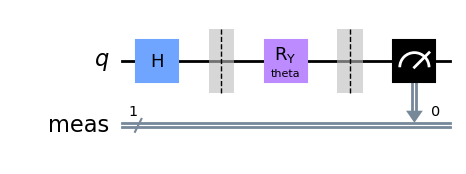

In [38]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw(output='mpl')


In [39]:
dataset_name = 'adhoc_10k'
df = pd.read_csv(f'datasets/{dataset_name}.csv', index_col=0)
feature_dimension = df.shape[1] - 1

all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=0.75, random_state=42)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.iloc[0:10, :].copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

test_loader = torch.utils.data.DataLoader(MyDataset(test_features, test_labels), batch_size=1, shuffle=True)

In [40]:
folds = 10
epochs = 100
loss_func = nn.CrossEntropyLoss
models = [
        HybridNNModel(
            Net(feature_dimension=feature_dimension, backend=simulator),
            fold=fold,
            loss_func=loss_func,
            epochs=epochs,
            dataset_name=dataset_name
        ) for fold in range(folds)
    ]

for i, model in enumerate(models):
    print(f'Loaded model {i+1}: {model.load()}')

Loaded model 1: True
Loaded model 2: True
Loaded model 3: True
Loaded model 4: True
Loaded model 5: True
Loaded model 6: True
Loaded model 7: True
Loaded model 8: True
Loaded model 9: True
Loaded model 10: True


/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 1 accuracy 60.00%
Fold 2 accuracy 70.00%
Fold 3 accuracy 30.00%
Fold 4 accuracy 30.00%
Fold 5 accuracy 80.00%
Fold 6 accuracy 40.00%
Fold 7 accuracy 40.00%
Fold 8 accuracy 50.00%
Fold 9 accuracy 50.00%
Fold 10 accuracy 50.00%
Accuracy mean: 50.0%, std: 15.491933384829668
best model: 4


{'whiskers': [<matplotlib.lines.Line2D at 0x17e8b9e20>,
 'caps': [<matplotlib.lines.Line2D at 0x17e9027c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x17e8b5730>],
 'medians': [<matplotlib.lines.Line2D at 0x17fb6e8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17e91bc10>],
 'means': []}

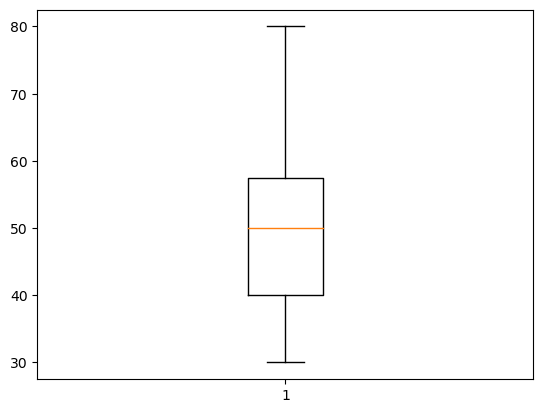

In [41]:
accuracies = np.array([model.score(test_loader) for model in models])
for i, model in enumerate(models):
    print('Fold %d accuracy %.2f%%' % (i+1, accuracies[i]))
print(f"Accuracy mean: {accuracies.mean()}%, std: {accuracies.std()}")
best_model_index = accuracies.argmax()
print(f"best model: {best_model_index}")
plt.boxplot(accuracies)

In [42]:
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ

# Best kernel should already be evaluated and set (in the above code cell)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='zhaw-1')
backend = least_busy(provider.backends(simulator=True))
print(f"Chosen backend: {backend}")
models[best_model_index].model.hybrid.quantum_circuit.backend = backend
models[best_model_index].score(test_loader)

ibmqfactory.load_account:WARNING:2023-01-14 19:14:15,933: Credentials are already in use. The existing account in the session will be replaced.


Chosen backend: ibmq_qasm_simulator


/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


80.0